In [78]:
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns


Imports

In [79]:
# df.to_feather(r'data/houses.feather')
X_train = pd.read_feather("data_model/X_train.feather")
y_train = pd.read_feather("data_model/y_train.feather")
X_test = pd.read_feather("data_model/X_test.feather")
y_test = pd.read_feather("data_model/y_test.feather")

# Convertit y en Series 1d
y_train = y_train.iloc[:,0]
y_test  = y_test.iloc[:,0]


In [80]:

X_train.head(1)

,rent_price,buy_price,n_bathrooms,sq_mt_built,price_per_m2,n_rooms,has_lift,has_parking,has_garden,has_storage_room,has_central_heating,has_pool
0,766.0,156000.0,1.0,78.0,2000.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
print(f"X_train : {X_train.shape}\ny_train : {y_train.shape}")

X_train : (17393, 12)
y_train : (17393,)


Entrainement du model

In [82]:

lr = LinearRegression()
lr.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [83]:
lr.score(X_train, y_train)

0.9266053254780569

POURQUOI LE RESULTAT EST AUSSI BON SUR LE TEST SET ?


IL ETAIT DE 0.62 AU DEBUT 

In [84]:
lr.score(X_test, y_test)

0.9270588533780024

In [85]:
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
print("R² CV moyenne :", scores.mean())


R² CV moyenne : 0.9262169664758959


In [86]:
# Génère des prédictions par validation croisée  (X_train uniquement)
y_train_pred = cross_val_predict(lr, X_train, y_train, cv=5)

# Calcul les résidus ( .flatten() force le format 1D)
y_train_flat = y_train.values.flatten()
residuals = y_train_flat - y_train_pred.flatten()

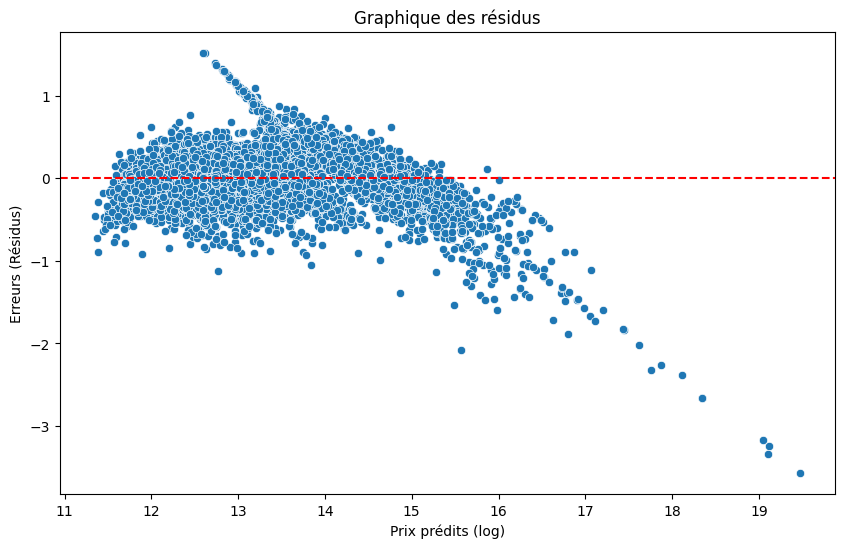

In [87]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred.ravel(), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à 0
plt.title('Graphique des résidus')
plt.xlabel('Prix prédits (log)')
plt.ylabel('Erreurs (Résidus)')
plt.show()

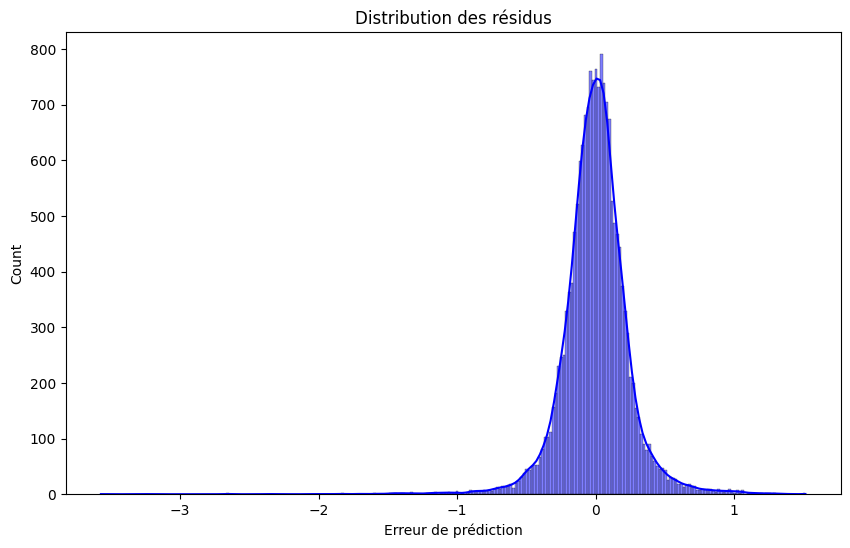

In [88]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution des résidus')
plt.xlabel('Erreur de prédiction')
plt.show()

In [89]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

rf.score(X_train, y_train)

0.9999994608633482

In [90]:
rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
print("R² CV moyenne :", rf_scores.mean())

R² CV moyenne : 0.9999927365450816


In [91]:
# # 49 valeurs
# k = np.arrange(1,50)
# # 49 valeurs sont testées avec cv=5
# train_score, val_score = validation_curve(model, X_train, y_train, 'n_neighbors', k, cv=5)

In [92]:

# # Sauvegarder
# with open("model.pkl", "wb") as f:
#     pickle.dump(model, f)

# print("✅ Modèle créé : model.pkl")

## CI DESSOUS : COPILOT

## Validation croisée et comparaison de modèles
Nous comparons plusieurs modèles via une validation croisée (5-fold) avec deux métriques: R² (à maximiser) et MAE (à minimiser).
Ensuite, nous ajustons chaque modèle sur l'ensemble d'entraînement et reportons les performances sur le test set pour vérifier la généralisation.

In [93]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Prépare y_train en 1D si nécessaire
# y_train_vec = y_train.squeeze()

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001, max_iter=5000),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, mdl in models.items():
    # R² en CV
    # cv_r2 = cross_val_score(mdl, X_train, y_train_vec, cv=cv, scoring='r2').mean()
    cv_r2 = cross_val_score(mdl, X_train, y_train, cv=cv, scoring='r2').mean()
    # MAE en CV (valeur positive)
    # cv_mae = -cross_val_score(mdl, X_train, y_train_vec, cv=cv, scoring='neg_mean_absolute_error').mean()
    cv_mae = -cross_val_score(mdl, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error').mean()
    
    # Fit et métriques sur test
    # mdl.fit(X_train, y_train_vec)
    mdl.fit(X_train, y_train)
    r2_test = mdl.score(X_test, y_test)
    y_pred_test = mdl.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    rows.append({
        'model': name,
        'cv_r2': cv_r2,
        'cv_mae': cv_mae,
        'test_r2': r2_test,
        'test_mae': mae_test
    })

results_df = pd.DataFrame(rows).sort_values(by=['cv_r2'], ascending=False)
results_df

,model,cv_r2,cv_mae,test_r2,test_mae
3,RandomForest,0.999994,0.000197,0.999999,0.000129
1,Ridge,0.926202,0.167319,0.927059,0.169519
0,LinearRegression,0.926202,0.167322,0.927059,0.169521
2,Lasso,0.926160,0.167029,0.926983,0.169205
